# Benchmarking Environment for Liar's Dice Game
(AA228 Final Project)

In [1]:
%load_ext autoreload
%autoreload 2
from src.game import LiarsDiceGame
from config import *
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

C:\Users\djmus\AppData\Local\Temp\ipykernel_7348\4198475644.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import torch
ckpt = torch.load("agents/agent_8.pt", map_location="cpu")
print("model_type:", ckpt.get("model_type"))
print("keys:",ckpt.keys())

model_type: dron_moe
keys: dict_keys(['policy_state', 'target_state', 'optimizer_state', 'episode', 'epsilon', 'step_count', 'wins', 'win_rate_history', 'stage_boundaries', 'memory', 'roster', 'model_type'])


## Testing

In [2]:
winner = LiarsDiceGame.game("wildcard_conservative", "random", save_json=True)
print(f"Winner is Player P{winner}")

Game over! Winner: P0. Game history saved to data\game_20251126_184648_55f26f.json
Winner is Player P0


## Settings

In [3]:
N_GAMES = 1000  # Number of games to simulate
latex_figsize = (6, 2)  # Figure size for LaTeX documents
latex_fontsize = 10  # Font size for LaTeX documents
save_path = "figures/benchmark/"  # Directory to save figures
os.makedirs(save_path, exist_ok=True)

# Single Configuration

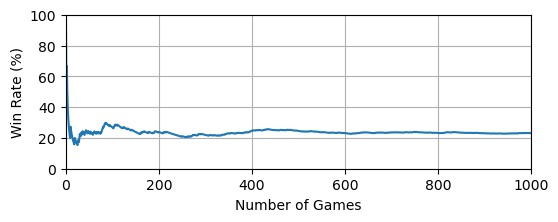

In [168]:
# config
player = "rand"
enemies = ["rand", "rand", "rand"]

# initialize win_rate
win_rate = np.zeros(N_GAMES)

for i in range(N_GAMES):
    winner = LiarsDiceGame.game(player, *enemies, save_json=False, dir=None)
    if i == 0:
        win_rate[i] = 1 if winner == 0 else 0
    else:
        if winner == 0:
            win_rate[i] = (win_rate[i-1] * i + 1) / (i + 1)
        else:
            win_rate[i] = (win_rate[i-1] * i) / (i + 1)

# plot results
plt.figure(figsize=latex_figsize)
plt.plot(win_rate * 100)
plt.xlabel("Number of Games", fontsize=latex_fontsize)
plt.ylabel("Win Rate (%)", fontsize=latex_fontsize)
plt.xlim(0, N_GAMES)
plt.ylim(0, 100)
plt.grid()

# All Configurations

In [5]:
# agents to test for
agents = ["wildcard_conservative", "wildcard_risky", "conservative", "risky"]
# configurations to test against
# versus_configs = [("random", "random", "random"),
#                   ("conservative", "conservative", "conservative"),
#                   ("risky", "risky", "risky"),
#                   ("wildcard_conservative", "wildcard_conservative", "wildcard_conservative"),
#                   ("wildcard_risky", "wildcard_risky", "wildcard_risky")]
versus_configs = [("random", "wildcard_risky"),
                  ("wildcard_risky", "wildcard_conservative"),
                  ("wildcard_conservative", "random"),
                  ("random", "random"),
                  ("wildcard_risky", "wildcard_risky"),
                  ("wildcard_conservative", "wildcard_conservative"),
                  ("conservative", "conservative"),
                  ("risky", "risky")]

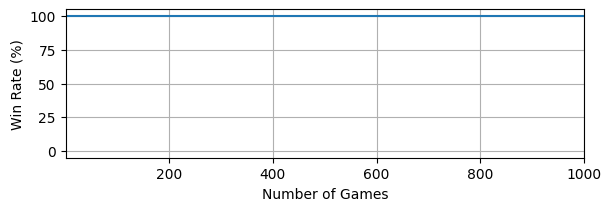

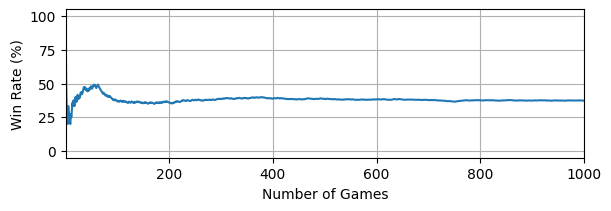

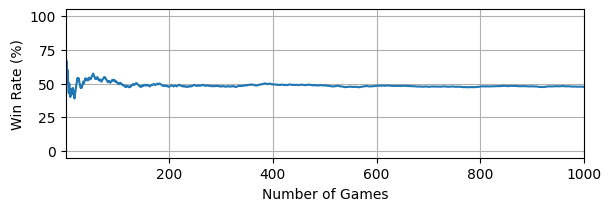

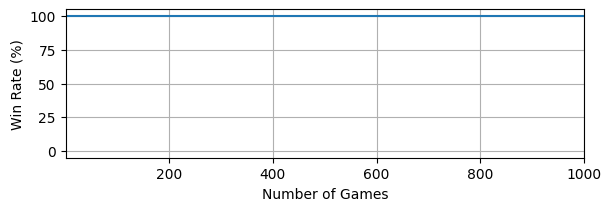

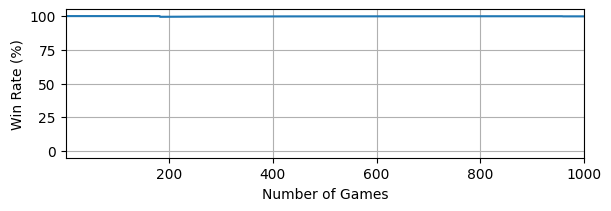

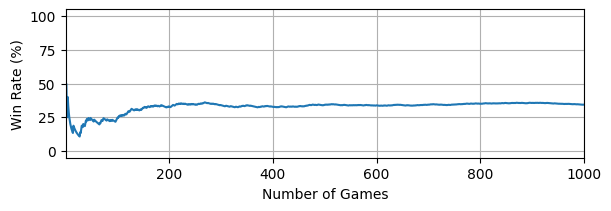

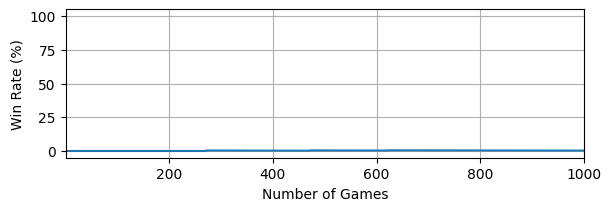

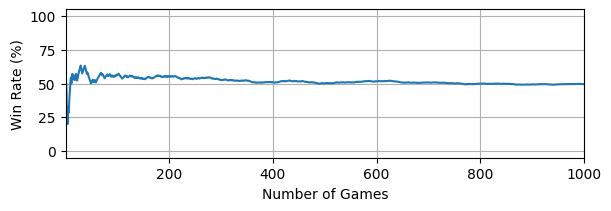

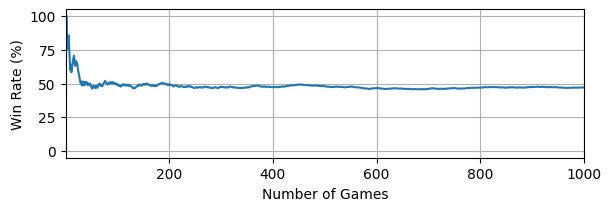

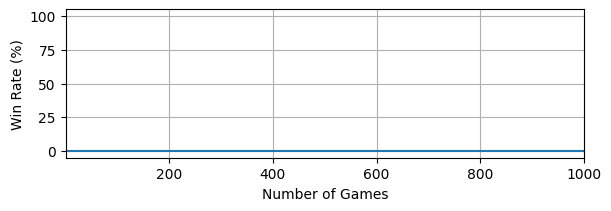

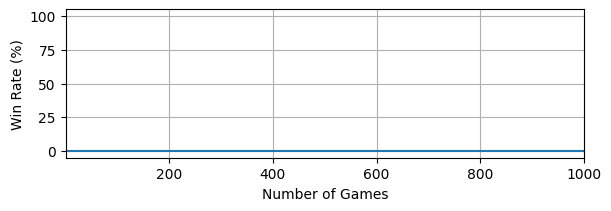

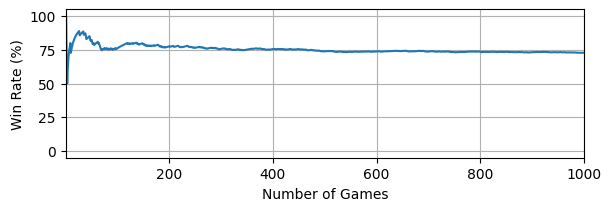

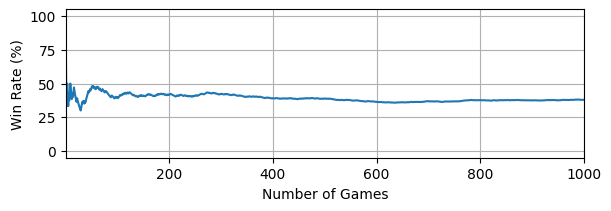

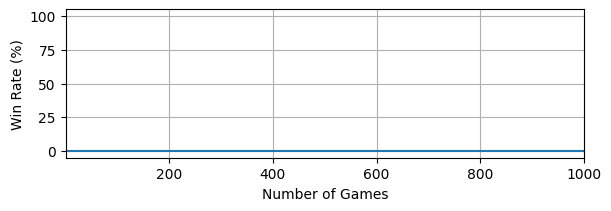

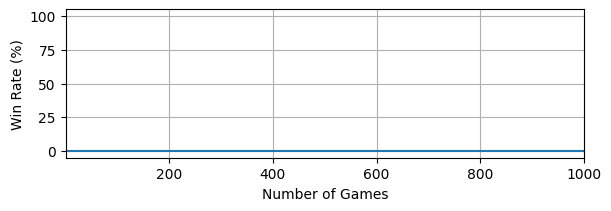

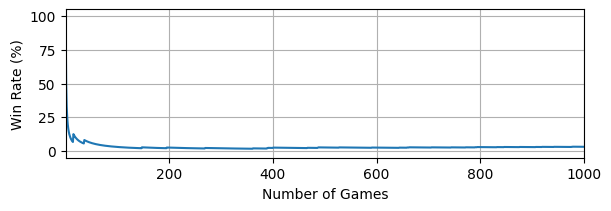

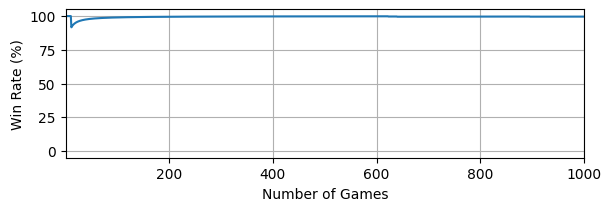

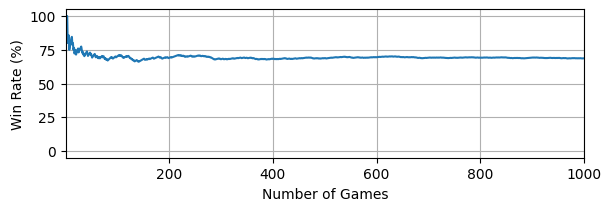

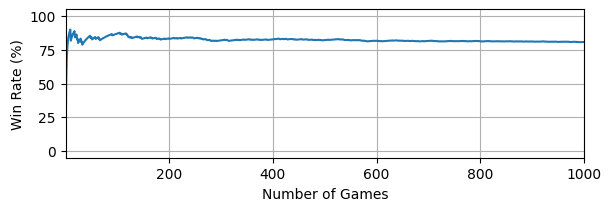

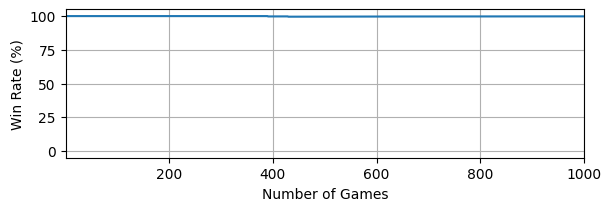

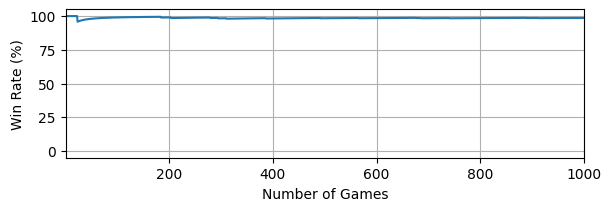

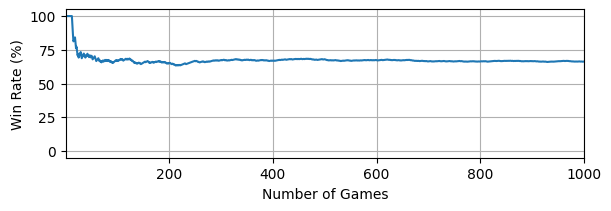

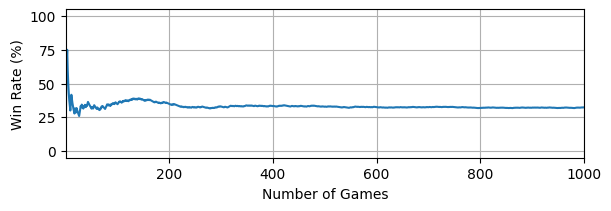

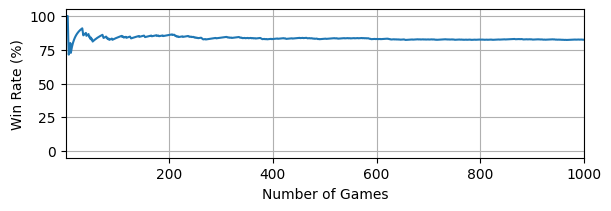

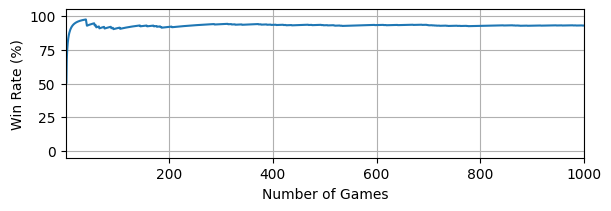

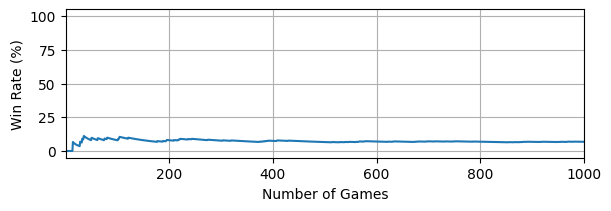

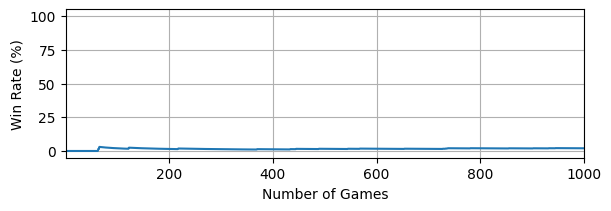

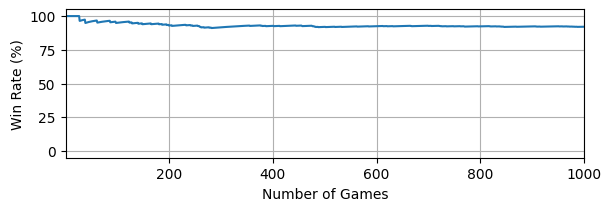

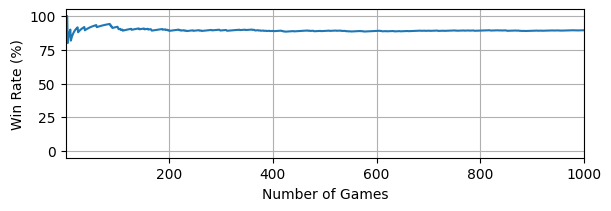

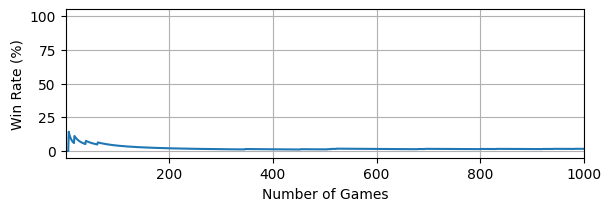

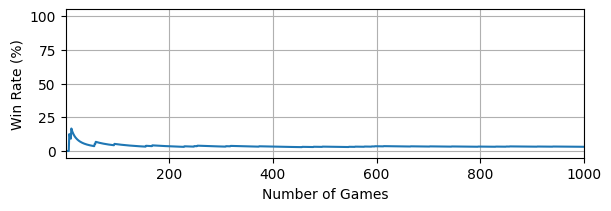

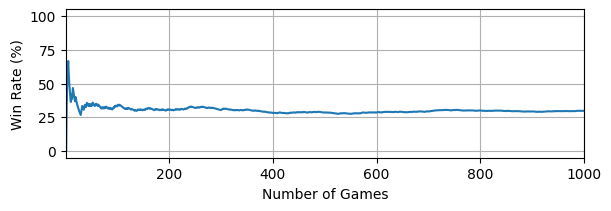

In [6]:
# Initialize win percentage matrix
win_rate_matrix = np.zeros((len(agents), len(versus_configs)))
# run all Configurations
for ag in agents:
    for j, vs in enumerate(versus_configs):
        win_rate = np.zeros(N_GAMES)
        for i in range(N_GAMES):
            players = (ag,) + vs
            winner = LiarsDiceGame.game(*players, save_json=False)
            if i == 0:
                win_rate[i] = 1 if winner == 0 else 0
            else:
                if winner == 0:
                    win_rate[i] = (win_rate[i - 1] * i + 1) / (i + 1)
                else:
                    win_rate[i] = (win_rate[i - 1] * i) / (i + 1)
        # plot and save results
        plt.subplots(figsize=latex_figsize, constrained_layout=True)
        plt.plot(range(1, N_GAMES + 1), win_rate * 100)
        plt.xlabel("Number of Games", fontsize=latex_fontsize)
        plt.ylabel("Win Rate (%)", fontsize=latex_fontsize)
        plt.xlim(1, N_GAMES)
        plt.ylim(-5, 105)
        plt.grid()
        plt.savefig(f"{save_path}{ag}_vs_{'_'.join(vs)}.pdf")
        plt.show()
        win_rate_matrix[agents.index(ag), j] = win_rate[-1]

In [7]:
# display win rate matrix as dataframe
label_map = {
    "random": "R",
    "conservative": "C",
    "risky": "A",
    "wildcard_conservative": "WC-C",
    "wildcard_risky": "WC-A"
}

win_df = pd.DataFrame(
        win_rate_matrix*100, 
        index=[label_map[ag] for ag in agents], 
        columns=[f"vs ({', '.join([label_map[v] for v in vs])})" for vs in versus_configs])
display(win_df)

,"vs (R, WC-A)","vs (WC-A, WC-C)","vs (WC-C, R)","vs (R, R)","vs (WC-A, WC-A)","vs (WC-C, WC-C)","vs (C, C)","vs (A, A)"
WC-C,100.0,37.3,47.5,100.0,99.8,34.3,0.3,49.6
WC-A,47.1,0.0,0.0,72.8,37.9,0.0,0.0,3.1
C,99.6,68.7,80.8,99.8,98.6,66.3,32.3,82.5
A,92.9,6.8,2.0,92.1,89.5,1.6,3.1,29.8


In [8]:
# assemble latex table
print("\\begin{table}[h!]\n\\centering\n\\scriptsize")
print(
"\\caption{Win rates for different agent configurations in LiarsDice game. \\\(R: Random, C: Conservative, A: Risky, WC-C: Wildcard Conservative, WC-A: Wildcard Risky).}\n"
)
print(win_df.to_latex(float_format=lambda x: f"$\\num{{{x:1.1f}}}$\%"))
print("\\end{table}")

\begin{table}[h!]
\centering
\scriptsize
\caption{Win rates for different agent configurations in LiarsDice game. \\(R: Random, C: Conservative, A: Risky, WC-C: Wildcard Conservative, WC-A: Wildcard Risky).}

\begin{tabular}{lrrrrrrrr}
\toprule
 & vs (R, WC-A) & vs (WC-A, WC-C) & vs (WC-C, R) & vs (R, R) & vs (WC-A, WC-A) & vs (WC-C, WC-C) & vs (C, C) & vs (A, A) \\
\midrule
WC-C & $\num{100.0}$\% & $\num{37.3}$\% & $\num{47.5}$\% & $\num{100.0}$\% & $\num{99.8}$\% & $\num{34.3}$\% & $\num{0.3}$\% & $\num{49.6}$\% \\
WC-A & $\num{47.1}$\% & $\num{0.0}$\% & $\num{0.0}$\% & $\num{72.8}$\% & $\num{37.9}$\% & $\num{0.0}$\% & $\num{0.0}$\% & $\num{3.1}$\% \\
C & $\num{99.6}$\% & $\num{68.7}$\% & $\num{80.8}$\% & $\num{99.8}$\% & $\num{98.6}$\% & $\num{66.3}$\% & $\num{32.3}$\% & $\num{82.5}$\% \\
A & $\num{92.9}$\% & $\num{6.8}$\% & $\num{2.0}$\% & $\num{92.1}$\% & $\num{89.5}$\% & $\num{1.6}$\% & $\num{3.1}$\% & $\num{29.8}$\% \\
\bottomrule
\end{tabular}

\end{table}
